# Evaluate yeast DNA regression model on test set

Here we evaluate the model we trained using the training set (90%) while monitoring performance on the validation set (5%). For evaluation, we use the held-out test set (5%) which was never imported into the Peltarion platform. The training/validation/test split is (as far as we know) the same as in the [Deep learning of the regulatory grammar of yeast 5′ untranslated regions from 500,000 random sequences](https://genome.cshlp.org/content/27/12/2015) paper, so we can directly compare with the figures in that paper.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn.metrics import explained_variance_score

import sidekick

As part of the data preparation, we exported Numpy arrays with training, validation and test input features (one-hot encoded DNA sequences) and labels. Now we load the test sequences and labels that were prepared then, and check that the shapes of the data look right.

In [2]:
X_test = np.load('yeast_seq_test.npy')
y_test = np.load('yeast_labels_test.npy')
print(X_test.shape)
print(y_test.shape)

(24468, 4, 70, 1)
(24468, 1)


Indeed, there are ~25,000 test examples, corresponding to 5% of the total of almost 500,000 sequences. The shape of the sequence data is (4, 70, 1), corresponding to 4 values for one-hot encoding the nucleotides A, C, G, T, 70 values for the 50 nucleotides with a padding of 10 on each side, and one dummy dimension that enables us to use 2D Convolution layers for processing these data. (The paper does it in the same way.)

The label has a single value, namely the growth rate, which is just a floating-point number.

Now we can make a Sidekick Deployment object:

In [4]:
client = sidekick.Deployment(
    url='<insert deployment URL>',
    token='<insert deployment token>',
    dtypes_in={'seq': 'Numpy (4x70x1)'},
    dtypes_out={'growth_rate': 'Numpy (1)'}
)

First check that this object works for predicting a single example before we move on to predicting all of them.

In [5]:
client.predict(seq=X_test[0])

{'growth_rate': array([0.7231469], dtype=float32)}

It works, so now we can move on to getting predictions for all of the test examples.

In [6]:
test_preds = client.predict_many([{'seq': x} for x in X_test])

The `predict_many()` method will return a list of dictionaries containing predictions which looks something like this:

```[{'growth_rate': array([0.72314715], dtype=float32)},
 {'growth_rate': array([-1.3992405], dtype=float32)},
 {'growth_rate': array([-1.3097613], dtype=float32)},
 [...]]```
 
So we need to extract the numerical predictions from each of these dictionaries by accessing the key `growth_rate`: 

In [7]:
y_pred = [x['growth_rate'][0] for x in test_preds]
y_pred[:10]

[0.72314715,
 -1.3992405,
 -1.3097613,
 -1.165137,
 0.31496584,
 -0.33979452,
 -1.0280567,
 -1.2866889,
 -1.2295036,
 0.31358492]

Now we have a normal list of floating point numbers, so we can make a plot like the one in figure 2A of the paper.

In [8]:
df = pd.DataFrame({'predicted': y_pred, 'actual': y_test.squeeze()})

## Scatter plot

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


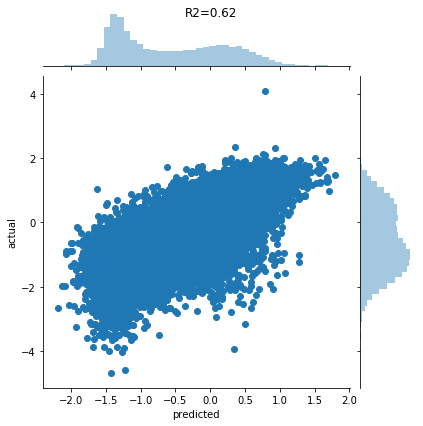

In [16]:
g = sb.jointplot(x="predicted", y="actual", data=df);
g.fig.suptitle("R2={:.2}".format(explained_variance_score(y_test, y_pred)));

## With point density

The plot above already gives something that looks like figure 2A in the paper. As we have a large number of data points (almost 25,000), it may also be helpful to see where most of the points are actually located.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


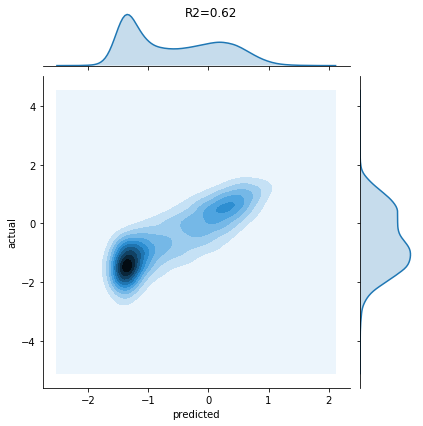

In [17]:
g = sb.jointplot(x="predicted", y="actual", data=df, kind="kde");
g.fig.suptitle("R2={:.2}".format(explained_variance_score(y_test, y_pred)));